<a href="https://colab.research.google.com/github/Ishita05Goel/StockmarketPrediction/blob/main/Copy_of_Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 2nd


Fetching data for RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed


Saved RELIANCE.NS_daily.csv and RELIANCE.NS_weekly.csv


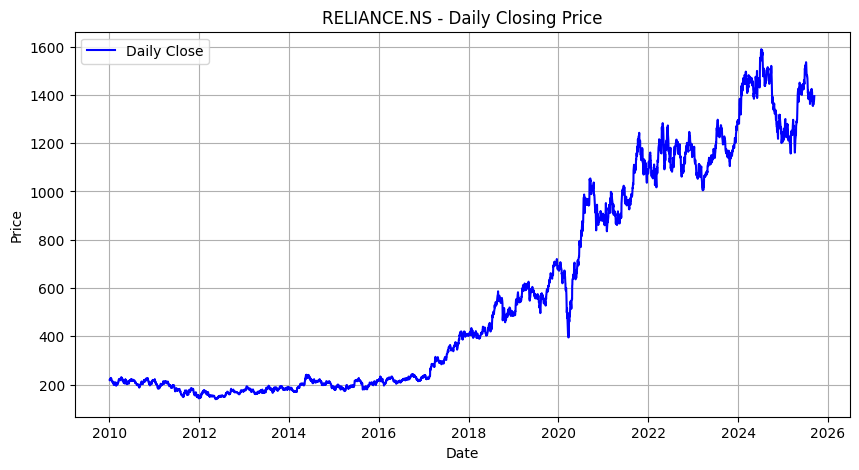

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


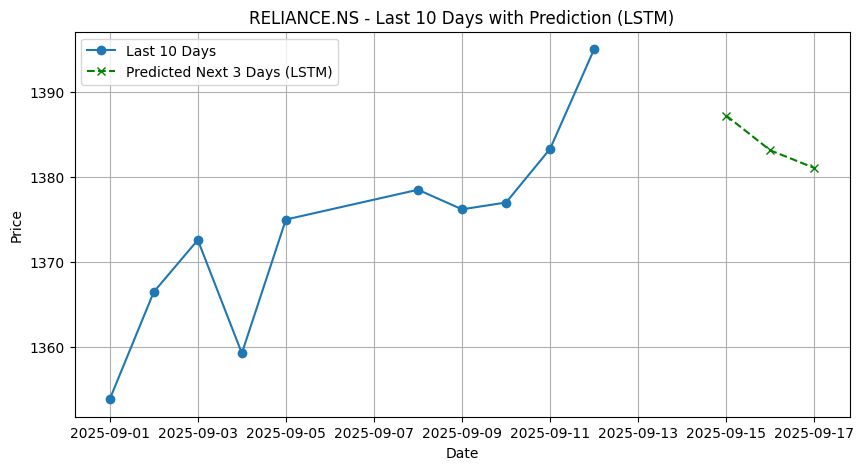

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


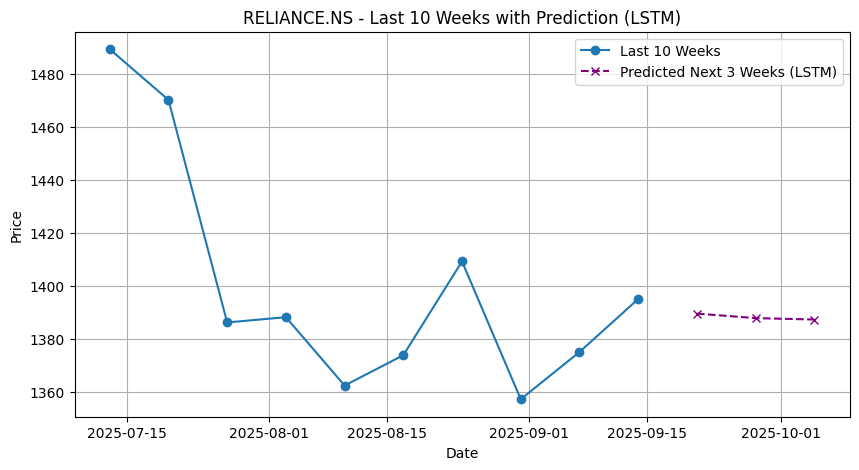

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def fetch_and_process_stock(ticker, start_date="2010-01-01"):
    print(f"\nFetching data for {ticker}...")

    # Download daily data
    df = yf.download(ticker, start=start_date, progress=True, auto_adjust=True)

    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Choose price column
    price_col = "Close" if "Close" in df.columns else "Adj Close"

    # Resample to week-end
    weekly_df = df.resample("W").agg({price_col: "last"})
    weekly_df.rename(columns={price_col: "Close"}, inplace=True)

    # Save CSVs
    df.to_csv(f"{ticker}_daily.csv")
    weekly_df.to_csv(f"{ticker}_weekly.csv")
    print(f"Saved {ticker}_daily.csv and {ticker}_weekly.csv")

    # ----------------------------
    # Graph 1: Daily Closing Price
    # ----------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[price_col], color="blue", label="Daily Close")
    plt.title(f"{ticker} - Daily Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 2: Last 10 Days + Predict next 3 days (LSTM)
    # ----------------------------
    last_10_days = df.tail(10).copy()
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(last_10_days[[price_col]])

    X, y = [], []
    for i in range(len(scaled_data)-1):
        X.append(scaled_data[i])
        y.append(scaled_data[i+1])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape for LSTM

    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=200, verbose=0)

    # Predict next 3 days
    last_value = scaled_data[-1].reshape(1,1,1)
    preds_scaled = []
    for _ in range(3):
        pred = model.predict(last_value, verbose=0)
        preds_scaled.append(pred[0][0])
        last_value = pred.reshape(1,1,1)

    future_preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    future_dates = pd.date_range(last_10_days.index[-1] + pd.Timedelta(days=1), periods=3, freq="B")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_days.index, last_10_days[price_col], marker="o", label="Last 10 Days")
    plt.plot(future_dates, future_preds, marker="x", linestyle="--", color="green", label="Predicted Next 3 Days (LSTM)")
    plt.title(f"{ticker} - Last 10 Days with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 3: Last 10 Weeks + Predict next 3 weeks (LSTM)
    # ----------------------------
    last_10_weeks = df.resample("W").agg({price_col: "last"}).tail(10).copy()
    scaler_w = MinMaxScaler()
    scaled_data_w = scaler_w.fit_transform(last_10_weeks[["Close"]])

    X_w, y_w = [], []
    for i in range(len(scaled_data_w)-1):
        X_w.append(scaled_data_w[i])
        y_w.append(scaled_data_w[i+1])
    X_w, y_w = np.array(X_w), np.array(y_w)
    X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

    model_w = Sequential([
        LSTM(50, activation="relu", input_shape=(X_w.shape[1], X_w.shape[2])),
        Dense(1)
    ])
    model_w.compile(optimizer="adam", loss="mse")
    model_w.fit(X_w, y_w, epochs=200, verbose=0)

    # Predict next 3 weeks
    last_value_w = scaled_data_w[-1].reshape(1,1,1)
    preds_scaled_w = []
    for _ in range(3):
        pred_w = model_w.predict(last_value_w, verbose=0)
        preds_scaled_w.append(pred_w[0][0])
        last_value_w = pred_w.reshape(1,1,1)

    future_preds_w = scaler_w.inverse_transform(np.array(preds_scaled_w).reshape(-1,1)).flatten()
    future_weeks = pd.date_range(last_10_weeks.index[-1] + pd.Timedelta(weeks=1), periods=3, freq="W")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_weeks.index, last_10_weeks["Close"], marker="o", label="Last 10 Weeks")
    plt.plot(future_weeks, future_preds_w, marker="x", linestyle="--", color="purple", label="Predicted Next 3 Weeks (LSTM)")
    plt.title(f"{ticker} - Last 10 Weeks with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, weekly_df

# Example usage
daily, weekly = fetch_and_process_stock("RELIANCE.NS")



Fetching data for GOOG...


[*********************100%***********************]  1 of 1 completed


Saved GOOG_daily.csv and GOOG_weekly.csv


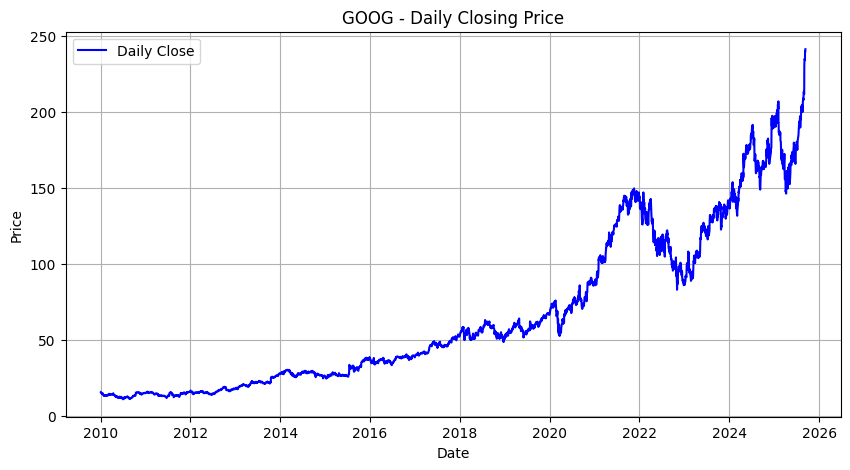

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


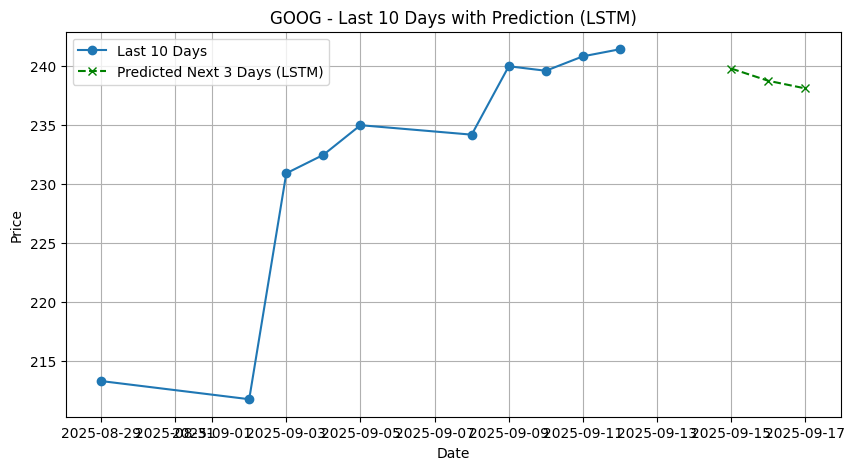

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


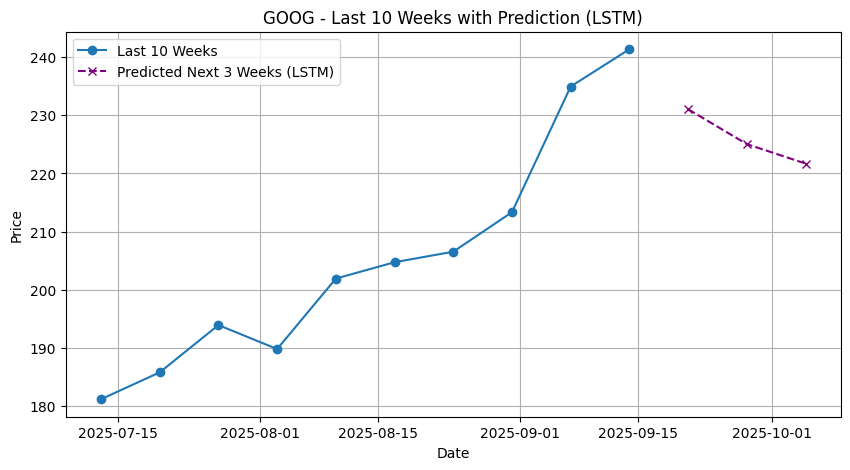

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def fetch_and_process_stock(ticker, start_date="2010-01-01"):
    print(f"\nFetching data for {ticker}...")

    # Download daily data
    df = yf.download(ticker, start=start_date, progress=True, auto_adjust=True)

    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Choose price column
    price_col = "Close" if "Close" in df.columns else "Adj Close"

    # Resample to week-end
    weekly_df = df.resample("W").agg({price_col: "last"})
    weekly_df.rename(columns={price_col: "Close"}, inplace=True)

    # Save CSVs
    df.to_csv(f"{ticker}_daily.csv")
    weekly_df.to_csv(f"{ticker}_weekly.csv")
    print(f"Saved {ticker}_daily.csv and {ticker}_weekly.csv")

    # ----------------------------
    # Graph 1: Daily Closing Price
    # ----------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[price_col], color="blue", label="Daily Close")
    plt.title(f"{ticker} - Daily Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 2: Last 10 Days + Predict next 3 days (LSTM)
    # ----------------------------
    last_10_days = df.tail(10).copy()
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(last_10_days[[price_col]])

    X, y = [], []
    for i in range(len(scaled_data)-1):
        X.append(scaled_data[i])
        y.append(scaled_data[i+1])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape for LSTM

    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=200, verbose=0)

    # Predict next 3 days
    last_value = scaled_data[-1].reshape(1,1,1)
    preds_scaled = []
    for _ in range(3):
        pred = model.predict(last_value, verbose=0)
        preds_scaled.append(pred[0][0])
        last_value = pred.reshape(1,1,1)

    future_preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    future_dates = pd.date_range(last_10_days.index[-1] + pd.Timedelta(days=1), periods=3, freq="B")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_days.index, last_10_days[price_col], marker="o", label="Last 10 Days")
    plt.plot(future_dates, future_preds, marker="x", linestyle="--", color="green", label="Predicted Next 3 Days (LSTM)")
    plt.title(f"{ticker} - Last 10 Days with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 3: Last 10 Weeks + Predict next 3 weeks (LSTM)
    # ----------------------------
    last_10_weeks = df.resample("W").agg({price_col: "last"}).tail(10).copy()
    scaler_w = MinMaxScaler()
    scaled_data_w = scaler_w.fit_transform(last_10_weeks[["Close"]])

    X_w, y_w = [], []
    for i in range(len(scaled_data_w)-1):
        X_w.append(scaled_data_w[i])
        y_w.append(scaled_data_w[i+1])
    X_w, y_w = np.array(X_w), np.array(y_w)
    X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

    model_w = Sequential([
        LSTM(50, activation="relu", input_shape=(X_w.shape[1], X_w.shape[2])),
        Dense(1)
    ])
    model_w.compile(optimizer="adam", loss="mse")
    model_w.fit(X_w, y_w, epochs=200, verbose=0)

    # Predict next 3 weeks
    last_value_w = scaled_data_w[-1].reshape(1,1,1)
    preds_scaled_w = []
    for _ in range(3):
        pred_w = model_w.predict(last_value_w, verbose=0)
        preds_scaled_w.append(pred_w[0][0])
        last_value_w = pred_w.reshape(1,1,1)

    future_preds_w = scaler_w.inverse_transform(np.array(preds_scaled_w).reshape(-1,1)).flatten()
    future_weeks = pd.date_range(last_10_weeks.index[-1] + pd.Timedelta(weeks=1), periods=3, freq="W")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_weeks.index, last_10_weeks["Close"], marker="o", label="Last 10 Weeks")
    plt.plot(future_weeks, future_preds_w, marker="x", linestyle="--", color="purple", label="Predicted Next 3 Weeks (LSTM)")
    plt.title(f"{ticker} - Last 10 Weeks with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, weekly_df

# Example usage
daily, weekly = fetch_and_process_stock("GOOG")



Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed


Saved AAPL_daily.csv and AAPL_weekly.csv


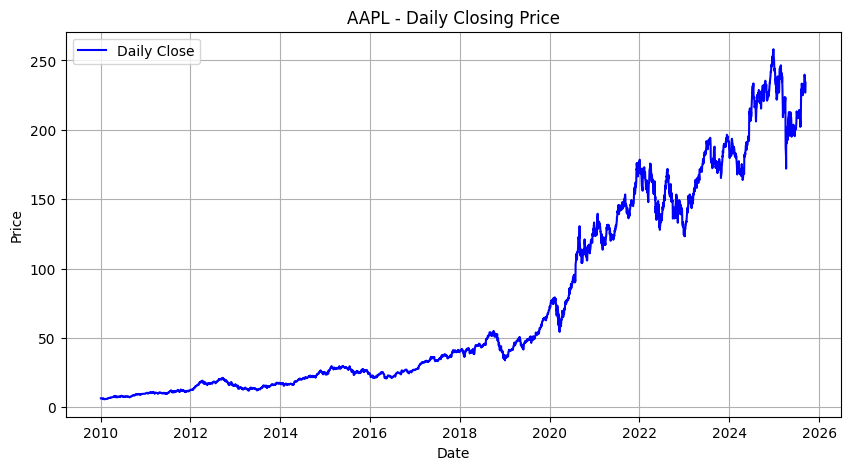

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


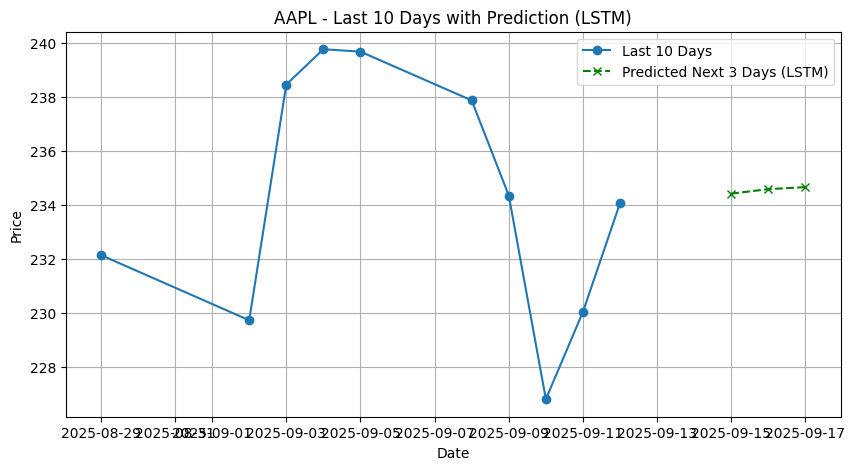

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


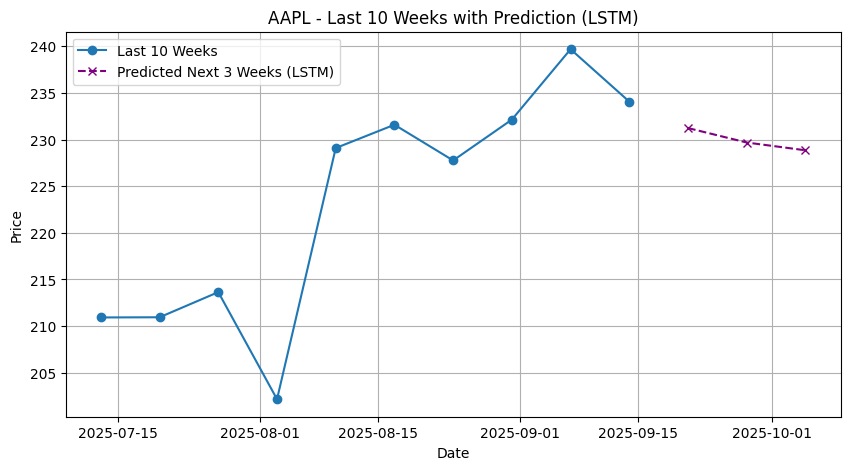

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def fetch_and_process_stock(ticker, start_date="2010-01-01"):
    print(f"\nFetching data for {ticker}...")

    # Download daily data
    df = yf.download(ticker, start=start_date, progress=True, auto_adjust=True)

    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Choose price column
    price_col = "Close" if "Close" in df.columns else "Adj Close"

    # Resample to week-end
    weekly_df = df.resample("W").agg({price_col: "last"})
    weekly_df.rename(columns={price_col: "Close"}, inplace=True)

    # Save CSVs
    df.to_csv(f"{ticker}_daily.csv")
    weekly_df.to_csv(f"{ticker}_weekly.csv")
    print(f"Saved {ticker}_daily.csv and {ticker}_weekly.csv")

    # ----------------------------
    # Graph 1: Daily Closing Price
    # ----------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[price_col], color="blue", label="Daily Close")
    plt.title(f"{ticker} - Daily Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 2: Last 10 Days + Predict next 3 days (LSTM)
    # ----------------------------
    last_10_days = df.tail(10).copy()
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(last_10_days[[price_col]])

    X, y = [], []
    for i in range(len(scaled_data)-1):
        X.append(scaled_data[i])
        y.append(scaled_data[i+1])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape for LSTM

    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=200, verbose=0)

    # Predict next 3 days
    last_value = scaled_data[-1].reshape(1,1,1)
    preds_scaled = []
    for _ in range(3):
        pred = model.predict(last_value, verbose=0)
        preds_scaled.append(pred[0][0])
        last_value = pred.reshape(1,1,1)

    future_preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    future_dates = pd.date_range(last_10_days.index[-1] + pd.Timedelta(days=1), periods=3, freq="B")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_days.index, last_10_days[price_col], marker="o", label="Last 10 Days")
    plt.plot(future_dates, future_preds, marker="x", linestyle="--", color="green", label="Predicted Next 3 Days (LSTM)")
    plt.title(f"{ticker} - Last 10 Days with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 3: Last 10 Weeks + Predict next 3 weeks (LSTM)
    # ----------------------------
    last_10_weeks = df.resample("W").agg({price_col: "last"}).tail(10).copy()
    scaler_w = MinMaxScaler()
    scaled_data_w = scaler_w.fit_transform(last_10_weeks[["Close"]])

    X_w, y_w = [], []
    for i in range(len(scaled_data_w)-1):
        X_w.append(scaled_data_w[i])
        y_w.append(scaled_data_w[i+1])
    X_w, y_w = np.array(X_w), np.array(y_w)
    X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

    model_w = Sequential([
        LSTM(50, activation="relu", input_shape=(X_w.shape[1], X_w.shape[2])),
        Dense(1)
    ])
    model_w.compile(optimizer="adam", loss="mse")
    model_w.fit(X_w, y_w, epochs=200, verbose=0)

    # Predict next 3 weeks
    last_value_w = scaled_data_w[-1].reshape(1,1,1)
    preds_scaled_w = []
    for _ in range(3):
        pred_w = model_w.predict(last_value_w, verbose=0)
        preds_scaled_w.append(pred_w[0][0])
        last_value_w = pred_w.reshape(1,1,1)

    future_preds_w = scaler_w.inverse_transform(np.array(preds_scaled_w).reshape(-1,1)).flatten()
    future_weeks = pd.date_range(last_10_weeks.index[-1] + pd.Timedelta(weeks=1), periods=3, freq="W")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_weeks.index, last_10_weeks["Close"], marker="o", label="Last 10 Weeks")
    plt.plot(future_weeks, future_preds_w, marker="x", linestyle="--", color="purple", label="Predicted Next 3 Weeks (LSTM)")
    plt.title(f"{ticker} - Last 10 Weeks with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, weekly_df

# Example usage
daily, weekly = fetch_and_process_stock("AAPL")



Fetching data for MSFT...


[*********************100%***********************]  1 of 1 completed


Saved MSFT_daily.csv and MSFT_weekly.csv


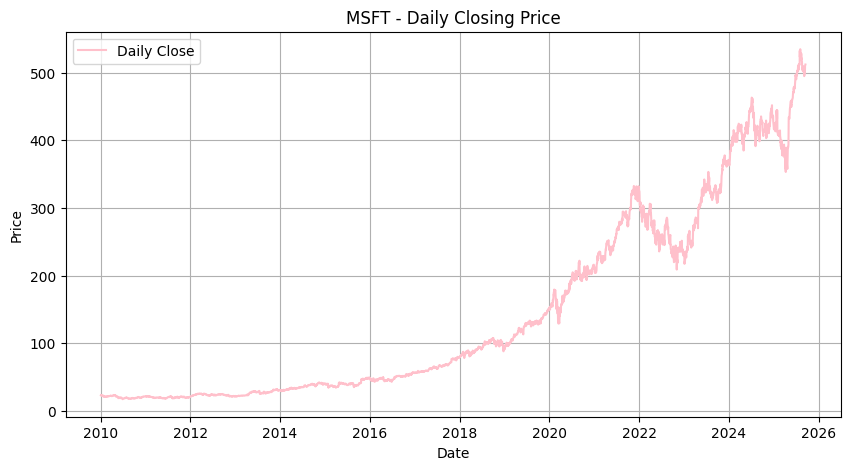

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


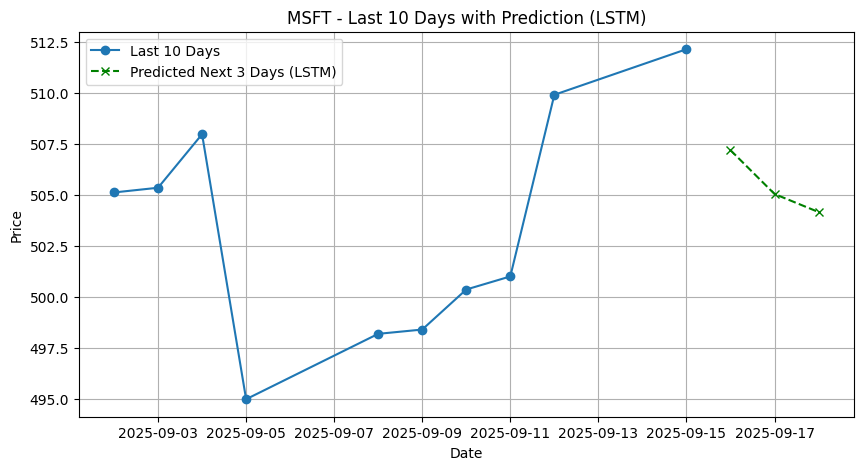

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


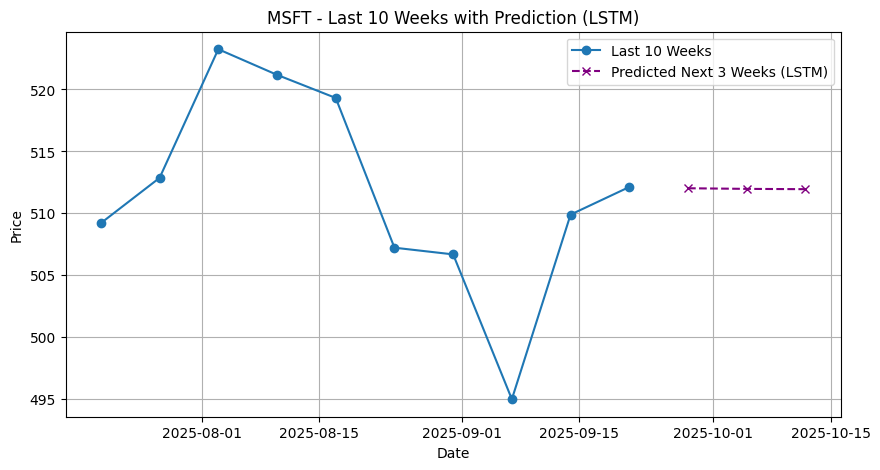

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def fetch_and_process_stock(ticker, start_date="2010-01-01"):
    print(f"\nFetching data for {ticker}...")

    # Download daily data
    df = yf.download(ticker, start=start_date, progress=True, auto_adjust=True) #Automatically adjusts the OHLC (Open, High, Low, Close) columns so they reflect the adjusted prices.
    # Flatten MultiIndex columns if present                                     #Removes the separate "Adj Close" column (because all OHLC are already adjusted).
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    # Ensure datetime index - to print it in datetime format...
    df.index = pd.to_datetime(df.index)

    # Choose price column
    price_col = "Close" if "Close" in df.columns else "Adj Close"

    # Resample to week-end
    weekly_df = df.resample("W").agg({price_col: "last"}) #groups data into week(ending on sunday - by default) and takes closing price.
    weekly_df.rename(columns={price_col: "Close"}, inplace=True)

    # Save CSVs
    df.to_csv(f"{ticker}_daily.csv")
    weekly_df.to_csv(f"{ticker}_weekly.csv")
    print(f"Saved {ticker}_daily.csv and {ticker}_weekly.csv")

    # Graph 1: Daily Closing Price

    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[price_col], color="pink", label="Daily Close")
    plt.title(f"{ticker} - Daily Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graph 2: Last 10 Days + Predict next 3 days (LSTM)

    last_10_days = df.tail(10).copy()                                #Takes last 10 days of stock price
    scaler = MinMaxScaler()                                          # Scale values between 0 and 1
    scaled_data = scaler.fit_transform(last_10_days[[price_col]])

    X, y = [], []
    for i in range(len(scaled_data)-1):
        X.append(scaled_data[i])
        y.append(scaled_data[i+1])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape for LSTM - changes shapes into 3D

    #Building LSTM Model
    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])), #Builds 50 layers of memory units(neurons).
        Dense(1) # final output layer = 1.
    ])
    model.compile(optimizer="adam", loss="mse") #use Adam optimizer, Mean Squared Error (mse) as loss.
    model.fit(X, y, epochs=200, verbose=0)

    # Predict next 3 days
    last_value = scaled_data[-1].reshape(1,1,1) #reshape into 3D shape - which LSTM expects.
    preds_scaled = []
    for _ in range(3):
        pred = model.predict(last_value, verbose=0)
        preds_scaled.append(pred[0][0])
        last_value = pred.reshape(1,1,1) #make this output input for the next prediction.

    future_preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten() #convert scaled value into original values and flatten convert it into 1D array.
    future_dates = pd.date_range(last_10_days.index[-1] + pd.Timedelta(days=1), periods=3, freq="B") #generates next three days.

    plt.figure(figsize=(10,5))
    plt.plot(last_10_days.index, last_10_days[price_col], marker="o", label="Last 10 Days")
    plt.plot(future_dates, future_preds, marker="x", linestyle="--", color="green", label="Predicted Next 3 Days (LSTM)")
    plt.title(f"{ticker} - Last 10 Days with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 3: Last 10 Weeks + Predict next 3 weeks (LSTM)
    # ----------------------------
    last_10_weeks = df.resample("W").agg({price_col: "last"}).tail(10).copy()
    scaler_w = MinMaxScaler()
    scaled_data_w = scaler_w.fit_transform(last_10_weeks[["Close"]])

    X_w, y_w = [], []
    for i in range(len(scaled_data_w)-1):
        X_w.append(scaled_data_w[i])
        y_w.append(scaled_data_w[i+1])
    X_w, y_w = np.array(X_w), np.array(y_w)
    X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

    model_w = Sequential([
        LSTM(50, activation="relu", input_shape=(X_w.shape[1], X_w.shape[2])),
        Dense(1)
    ])
    model_w.compile(optimizer="adam", loss="mse")
    model_w.fit(X_w, y_w, epochs=200, verbose=0)

    # Predict next 3 weeks
    last_value_w = scaled_data_w[-1].reshape(1,1,1)
    preds_scaled_w = []
    for _ in range(3):
        pred_w = model_w.predict(last_value_w, verbose=0)
        preds_scaled_w.append(pred_w[0][0])
        last_value_w = pred_w.reshape(1,1,1)

    future_preds_w = scaler_w.inverse_transform(np.array(preds_scaled_w).reshape(-1,1)).flatten()
    future_weeks = pd.date_range(last_10_weeks.index[-1] + pd.Timedelta(weeks=1), periods=3, freq="W")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_weeks.index, last_10_weeks["Close"], marker="o", label="Last 10 Weeks")
    plt.plot(future_weeks, future_preds_w, marker="x", linestyle="--", color="purple", label="Predicted Next 3 Weeks (LSTM)")
    plt.title(f"{ticker} - Last 10 Weeks with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, weekly_df

# Example usage
daily, weekly = fetch_and_process_stock("MSFT")


In [ ]:
pip install yfinance newsapi-python nltk


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
!pip install yahoo_fin yfinance nltk

from yahoo_fin import news
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_yahoo_sentiment(ticker):
    """
    Fetches latest Yahoo Finance news for a stock ticker and runs sentiment analysis
    """
    articles = news.get_yf_rss(ticker)
    if not articles:
        return None, "No News"

    scores = []
    for art in articles[:10]:  # Take top 10 recent news
        title = art["title"]
        sentiment = sia.polarity_scores(title)
        scores.append(sentiment["compound"])

    if not scores:
        return None, "No News"

    avg_score = sum(scores) / len(scores)
    if avg_score > 0.2:
        label = "Positive"
    elif avg_score < -0.2:
        label = "Negative"
    else:
        label = "Neutral"

    return round(avg_score, 3), label

# Example: Reliance, Google, Apple, Microsoft
companies = ["RELIANCE.NS", "GOOG", "AAPL", "MSFT"]

results = {}
for ticker in companies:
    score, label = get_yahoo_sentiment(ticker)
    results[ticker] = {"Sentiment Score": score, "Sentiment Label": label}

import pandas as pd
sentiment_df = pd.DataFrame(results).T
print(sentiment_df)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pyppeteer to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pyppeteer to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 12.8 MB/s eta 0:00:00
  Created wheel for pyppeteer: filename=pyppeteer-0.0.25-py3-none-any.whl size=78356 sha256=68acbd71a27a8b844cd3b41c38055f65538641eec8cb9fd87538c86fa3e80045
  Stored in directory: /root/.cache/pip/wheels/9c/7e/08/1d19cd4b0f6d57363170cf9538d65a7285e6aba8731bac8813
  Created wheel for sgmllib3k: filenam

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


            Sentiment Score Sentiment Label
RELIANCE.NS            None         No News
GOOG                  0.141         Neutral
AAPL                  0.145         Neutral
MSFT                  0.223        Positive
